tgb - 9/23/2019 - The goal of this notebook is to reproduce the target figures for Noah's interpretable ML paper

In [1]:
from cbrain.imports import *
from cbrain.data_generator import *
from cbrain.cam_constants import *
from cbrain.losses import *
from cbrain.utils import limit_mem
from cbrain.layers import *
import tensorflow as tf
import tensorflow.math as tfm
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import xarray as xr
import numpy as np
from cbrain.model_diagnostics import ModelDiagnostics
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as imag
import math

# Otherwise tensorflow will use ALL your GPU RAM for no reason
limit_mem()

TRAINDIR = '/local/Tom.Beucler/SPCAM_PHYS/'
DATADIR = '/project/meteo/w2w/A6/S.Rasp/SP-CAM/fluxbypass_aqua/'
PREFIX = '8col009_01_'
%cd /filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM

/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages

/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog
/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM


In [2]:
coor = xr.open_dataset("/project/meteo/w2w/A6/S.Rasp/SP-CAM/fluxbypass_aqua/AndKua_aqua_SPCAM3.0_sp_fbp_f4.cam2.h1.0000-01-01-00000.nc",\
                    decode_times=False)
lat = coor.lat; lon = coor.lon;
coor.close();

# 1) Figure 2

tgb - 9/23/2019 - This figures bins all variables used for training as a function of two convection proxys:  
Lower-tropospheric stability:  
$$
\mathrm{LTS}=\theta\left(700\mathrm{hPa}\right)-\mathrm{SST}
$$  
Mid-tropospheric moisture:  
$$
Q_{m}=\int_{600\mathrm{hPa}}^{850\mathrm{hPa}}\frac{dp}{g}q_{v}
$$



## 1.1) Define models

In [3]:
# Config and data files
config_fn = '/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/pp_config/8col_rad_tbeucler_local_PostProc.yml'
data_fn_a = ['/local/Tom.Beucler/SPCAM_PHYS/8col009_01_valid.nc']
data_ref = ['']
dict_lay = {'SurRadLayer':SurRadLayer,'MassConsLayer':MassConsLayer,'EntConsLayer':EntConsLayer,\
           'weak_loss_0':mse,'weak_loss_1':mse}
NNarray = ['JNNL','JNNC','MLRL0','JNNL0.01']

In [4]:
index = 0; # Choose dataset from data_fn_a [0 is +0K of length 5172]

NN = {}; md = {};
%cd $TRAINDIR/HDF5_DATA
for i,NNs in enumerate(NNarray):
    print('NN name is ',NNs)
    path = TRAINDIR+'HDF5_DATA/'+NNs+'.h5'
    NN[NNs] = load_model(path,custom_objects=dict_lay)
    md[NNs] = ModelDiagnostics(NN[NNs],config_fn,data_fn_a[index])

W0924 18:18:13.499771 22475568305984 deprecation.py:506] From /home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:97: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0924 18:18:13.500568 22475568305984 deprecation.py:506] From /home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


/scratch-local/Tom.Beucler/SPCAM_PHYS/HDF5_DATA
NN name is  JNNL


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


NN name is  JNNC


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
W0924 18:18:17.478055 22475568305984 deprecation.py:506] From /home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


NN name is  MLRL0


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


NN name is  JNNL0.01


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


## 1.2) Constants

In [5]:
def nearest_index(array, value):
    idx = (np.abs(array-value)).argmin()
    return idx

In [113]:
# User's choice
latTROP = [-22.5,22.5]
Nt = 500
iTROP = np.where((coor.lat>=latTROP[0])*(coor.lat<=latTROP[1]))
pTBL = 850
pLTS = 700
pMT = 600
iTBL = nearest_index(coor.lev,pTBL).values
iLTS = nearest_index(coor.lev,pLTS).values
iMT = nearest_index(coor.lev,pMT).values

In [114]:
# Constants and conversion factor
kappa = 287.058/1004 # Poisson Constant to define potential temperature
p0 = 1015 # Pressure of sea surface (from Noah's paper)
P_CONV = 1e3*24*3600 # Conversion from m/s to mm/day
theta_p = ((p0/coor.lev)**kappa).values # Vertical factor to calculate potential temperature
SST = coor.TS[0,:,0] # Sea surface temperature

## 1.3) Accumulate fields

In [115]:
NNname = 'JNNL' # Use any network to get inputs and truth

# Initialization
Qmid = np.zeros((len(iTROP[0]),len(coor.lon),1))
LTS = Qmid
QVtrop = np.zeros((len(iTROP[0]),len(coor.lon),len(coor.lev),1))
PREC_NN = {}; HEAT_NN = {}; dTdt_NN = {}; dqdt_NN = {};
for iNN,NNname in enumerate(NNarray):
    PREC_NN[NNname] = np.zeros((len(iTROP[0]),len(coor.lon),1))
    HEAT_NN[NNname] = PREC_NN[NNname]
    dTdt_NN[NNname] = np.zeros((len(iTROP[0]),len(coor.lon),len(coor.lev),1))
    dqdt_NN[NNname] = dTdt_NN[NNname]
                               
PREC_NN['truth'] = PREC_NN[NNname]
HEAT_NN['truth'] = HEAT_NN[NNname]
dTdt_NN['truth'] = dTdt_NN[NNname]
dqdt_NN['truth'] = dqdt_NN[NNname]

In [116]:
for itime in range(Nt):
    print('itime=',itime,'/',Nt-1,end="\r")
    m = md[NNname]
    if itime==0: dP = m.dP(0)
    # Inputs and truth
    X, truth = m.valid_gen[itime]
    
    # Mid-tropospheric moisture
    QV = m.valid_gen.input_transform.inverse_transform(X)[:,m.get_input_var_idx('QBP')]
    QVgeo = m.reshape_ngeo(QV.values)[iTROP,:,:]
    QVtrop = np.concatenate((QVtrop,np.expand_dims(QVgeo[0,:,:,:],axis=3)),axis=3)
    QMgeo = m.reshape_ngeo(np.expand_dims(np.sum(dP[:,iMT:(iTBL+0)]*QV[:,iMT:(iTBL+0)]/G,axis=1),axis=1))
    Qmid = np.concatenate((Qmid,QMgeo[iTROP,:,:][0,:,:,:]),axis=2)
    # Lower-tropospheric stability
    T = m.valid_gen.input_transform.inverse_transform(X)[:,m.get_input_var_idx('TBP')]
    TLTSgeo = m.reshape_ngeo(T.values*theta_p)[:,:,iLTS]-np.transpose(np.tile(SST,(len(coor.lon),1)))
    LTS = np.concatenate((LTS,np.moveaxis(TLTSgeo[iTROP,:],0,2)),axis=2)
    
    # Precipitation-Evaporation 
    # From NN prediction
    for iNN,NNname in enumerate(NNarray):
        m = md[NNname]
        pred = m.model.predict_on_batch(X)
        PRECIP_NN = np.sum(pred[:,-4:],axis=1)-\
        m.valid_gen.input_transform.inverse_transform(X)[:,m.get_input_var_idx('LHFLX')][:,0].values
        PREC_NN[NNname] = np.concatenate((PREC_NN[NNname],
                                          m.reshape_ngeo(P_CONV/(L_V*RHO_L)*PRECIP_NN)[iTROP,:,:][0,:,:,:]),axis=2)
    # Truth
    PRECIP = np.sum(truth[:,-4:].values,axis=1)-\
    m.valid_gen.input_transform.inverse_transform(X)[:,m.get_input_var_idx('LHFLX')][:,0].values
    PREC_NN['truth'] = np.concatenate((PREC_NN['truth'],
                                       m.reshape_ngeo(P_CONV/(L_V*RHO_L)*PRECIP)[iTROP,:,:][0,:,:,:]),axis=2)
    
    # Net heating 
    # From NN prediction
    for iNN,NNname in enumerate(NNarray):
        m = md[NNname]
        pred = m.model.predict_on_batch(X)
        HEA_NN = m.reshape_ngeo(np.expand_dims(np.sum(pred[:,90:120],axis=1),axis=1))[iTROP,:,:][0,:,:,:]
        HEAT_NN[NNname] = np.concatenate((HEAT_NN[NNname],HEA_NN),axis=2)
    # Truth
    HEA_NN = m.reshape_ngeo(np.expand_dims(np.sum(truth[:,90:120].values,axis=1),axis=1))[iTROP,:,:][0,:,:,:]
    HEAT_NN['truth'] = np.concatenate((HEAT_NN['truth'],HEA_NN),axis=2)
    
    # Heating profile
    # From NN prediction
    for iNN,NNname in enumerate(NNarray):
        m = md[NNname]
        pred = m.model.predict_on_batch(X)
        dT_NN = m.reshape_ngeo(pred[:,90:120])[iTROP,:,:]
        dTdt_NN[NNname] = np.concatenate((dTdt_NN[NNname],np.moveaxis(dT_NN,0,3)),axis=3)
    # Truth
    dT_NN = m.reshape_ngeo(truth[:,90:120].values)[iTROP,:,:]
    dTdt_NN['truth'] = np.concatenate((dTdt_NN['truth'],np.moveaxis(dT_NN,0,3)),axis=3)
    
    # Moistening profile
    # From NN prediction
    for iNN,NNname in enumerate(NNarray):
        m = md[NNname]
        pred = m.model.predict_on_batch(X)
        dq_NN = m.reshape_ngeo(pred[:,:30])[iTROP,:,:]
        dqdt_NN[NNname] = np.concatenate((dqdt_NN[NNname],np.moveaxis(dq_NN,0,3)),axis=3)
    # Truth
    dq_NN = m.reshape_ngeo(truth[:,:30].values)[iTROP,:,:]
    dqdt_NN['truth'] = np.concatenate((dqdt_NN['truth'],np.moveaxis(dq_NN,0,3)),axis=3)

In [117]:
# Remove initial zero
QVtrop = QVtrop[:,:,:,1:]
Qmid = Qmid[:,:,1:]
LTS = LTS[:,:,1:]
for iNN,NNname in enumerate(NNarray):
    PREC_NN[NNname] = PREC_NN[NNname][:,:,1:]
    HEAT_NN[NNname] = HEAT_NN[NNname][:,:,1:]
    dTdt_NN[NNname] = dTdt_NN[NNname][:,:,:,1:]
    dqdt_NN[NNname] = dqdt_NN[NNname][:,:,:,1:]
PREC_NN['truth'] = PREC_NN['truth'][:,:,1:]
HEAT_NN['truth'] = HEAT_NN['truth'][:,:,1:]
dTdt_NN['truth'] = dTdt_NN['truth'][:,:,:,1:]
dqdt_NN['truth'] = dqdt_NN['truth'][:,:,:,1:]

## 1.4) Take conditional expectation

In [118]:
# Histogram parameters
Nbin = 20
LTSmin = 7
LTSmax = 23
QMmin = 0
QMmax = 40

In [119]:
STR = np.concatenate((NNarray,['truth'])) # String array containing all NNs + 'truth'
Whist = np.zeros((Nbin-1,Nbin-1))
PREChist = {}; HEAThist = {}; dTdthist = {}; dqdthist = {};
for iNN,NNname in enumerate(STR):
    PREChist[NNname] = np.zeros((Nbin-1,Nbin-1)) 
    HEAThist[NNname] = np.zeros((Nbin-1,Nbin-1))
    dTdthist[NNname] = np.zeros((Nbin-1,Nbin-1,len(coor.lev)))
    dqdthist[NNname] = np.zeros((Nbin-1,Nbin-1,len(coor.lev)))

LTSspace = np.linspace(LTSmin,LTSmax,num=Nbin)
QMspace = np.linspace(QMmin,QMmax,num=Nbin)

for binLTS,edgeLTS in enumerate(LTSspace):
    print('binLTS=',binLTS,'/',Nbin-1,' & edgeLTS=',edgeLTS,end="\r")
    if binLTS>0:
        for binQM,edgeQM in enumerate(QMspace):
            if binQM>0:
                w = (LTS>=edgeLTS_left)*(LTS<edgeLTS)*(Qmid>=edgeQM_left)*(Qmid<edgeQM)
                Whist[binQM-1,binLTS-1] = np.sum(w)
                for iNN,NNname in enumerate(STR):
                    if Whist[binQM-1,binLTS-1]==0: 
                        PREChist[NNname][binQM-1,binLTS-1]=np.nan
                        HEAThist[NNname][binQM-1,binLTS-1]=np.nan
                        dTdthist[NNname][binQM-1,binLTS-1,:]=np.nan*dTdthist[NNname][binQM-1,binLTS-1,:]
                        dqdthist[NNname][binQM-1,binLTS-1,:]=np.nan*dqdthist[NNname][binQM-1,binLTS-1,:]
                    else: 
                        PREChist[NNname][binQM-1,binLTS-1]=np.average(PREC_NN[NNname],weights=w)
                        HEAThist[NNname][binQM-1,binLTS-1]=np.average(HEAT_NN[NNname],weights=w)
                        dTdthist[NNname][binQM-1,binLTS-1,:]=np.average(dTdt_NN[NNname],
                                                                        weights=np.moveaxis(np.tile(w,(30,1,1,1)),0,2))
                        dqdthist[NNname][binQM-1,binLTS-1,:]=np.average(dqdt_NN[NNname],
                                                                        weights=np.moveaxis(np.tile(w,(30,1,1,1)),0,2))
            edgeQM_left = edgeQM
    edgeLTS_left = edgeLTS

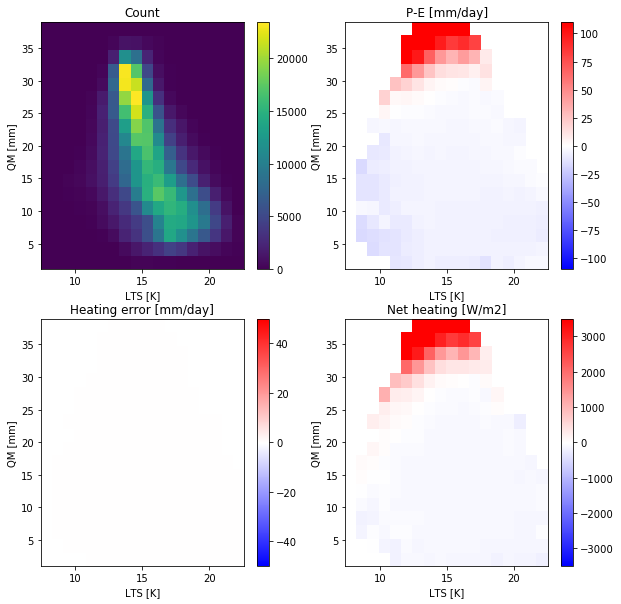

In [138]:
X = 0.5*(LTSspace[:-1]+LTSspace[1:])
Y = 0.5*(QMspace[:-1]+QMspace[1:])

NNname = 'truth'

option_array = ['Weights','Precip','Hano','Heating']

fig, ax = plt.subplots(2,2,figsize=(10,10))

for i,option in enumerate(option_array):
    
    if option=='Weights': C = Whist; vlim=False; tit='Count'; cmaps = 'viridis'
    elif option=='Precip': C = PREChist[NNname]; vlim=True; vmin = -110; vmax = 110; cmaps = 'bwr'; tit='P-E [mm/day]'
    elif option=='Heating': C = HEAThist[NNname]; vlim=True; vmin = -3.5e3; vmax = 3.5e3; cmaps = 'bwr'; tit='Net heating [W/m2]'
    elif option=='Pano': C = PREChist[NNname]-PREChist['truth']; vlim=True; vmin = -11; vmax = 11; cmaps = 'bwr'; tit='P-E error [mm/day]'
    elif option=='Hano': C = HEAThist[NNname]-HEAThist['truth']; vlim=True; vmin = -50; vmax = 50; cmaps = 'bwr'; tit='Heating error [mm/day]'

    ax0 = ax[math.floor(i/2),i%2]
    if vlim: im = ax0.pcolormesh(X, Y, C, vmin=vmin, vmax=vmax, cmap=cmaps)
    else: im = ax0.pcolormesh(X, Y, C, cmap=cmaps)

    plt.colorbar(im, ax=ax0)
    ax0.set_xlabel('LTS [K]')
    ax0.set_ylabel('QM [mm]')
    ax0.set_title(tit)
    
plt.savefig('/home/t/Tom.Beucler/Fig2'+NNname+'.pdf',format='pdf')

In [133]:
PREChist[NNname][-1,:]

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan])